In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from bbox_plotter import yolo_to_corners
from torchvision.ops import complete_box_iou_loss
from PIL import Image
import numpy as np
import csv
import os
from bbox_plotter import visualize_prediction

In [2]:
class ZebrafishDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
    

In [3]:
images_path = "D:\Praharsha\Code\CAMZ\data\interim\X_labelled_data.npy"
labels_path = "D:\Praharsha\Code\CAMZ\data\interim\y_labelled_data.npy"

transform = transforms.ToTensor()
dataset = ZebrafishDataset(images_path, labels_path, transform=transform)

train_size = int(0.8 * dataset.__len__())
val_size = dataset.__len__() - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [4]:
train_loader = DataLoader(dataset = train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size=32, shuffle=True)

In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((8, 8))  

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features= 128 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=4)
        
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.global_avg_pool(self.pool3(torch.relu(self.conv3(x))))
                
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x
        

In [6]:
class CompleteBoxLoss(nn.Module):
    def __init__(self):
        super(CompleteBoxLoss, self).__init__()

    def forward(self, pred_boxes, true_boxes, reduction):
        ciou = complete_box_iou_loss(pred_boxes, true_boxes, reduction)
        
        return ciou


In [7]:
model = CNNModel().to('cuda')
ciou_loss_function = CompleteBoxLoss().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(8, 8))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [9]:
def Initialize_writer(file_path):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, mode='w', newline="") as file:
        writer = csv.writer(file)
        writer.writerow(['epoch', 'loss', 'val_loss'])

In [10]:
def validate(model, val_loader, loss_function):
    model.eval()
    ciou_total_batch_loss = 0.0
    
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            outputs = yolo_to_corners(model(inputs), image_width=720, image_height=720)
            labels = yolo_to_corners(labels, image_width=720, image_height=720)
            
            ciou_loss_per_batch = loss_function(outputs, labels, 'mean')
            
            ciou_total_batch_loss += ciou_loss_per_batch.item()
        
        
        ciou_total_loss = ciou_total_batch_loss / len(val_loader)
        
        
        print(f"CIoU: {ciou_total_loss:.4f}", end=" ")
        return ciou_total_loss

In [11]:
def train(model, train_loader, optimizer, 
          loss_function,
          history_csv_path, 
          save_model_checkpoint_path, num_epochs=100, patience=10, delta=0.001, lambda_l1=0.01):
    
    Initialize_writer(history_csv_path)
    
    best_val_ciou_loss = float('inf')
    early_stopping = 0  # Initialize early stopping counter
    
    model.train()
        
    for epoch in range(num_epochs):
        ciou_total_batch_loss = 0.0
         
        for inputs, labels in train_loader:
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            
            optimizer.zero_grad()
            
            norm_labels = yolo_to_corners(labels, image_width=720, image_height=720)
            outputs = yolo_to_corners(model(inputs), image_width=720, image_height=720)
            
            # Compute CIoU loss
            ciou_loss_per_batch = loss_function(outputs, norm_labels, 'mean')
            
            # Compute L1 regularization loss
            l1_loss = 0.0
            for param in model.parameters():
                l1_loss += torch.sum(torch.abs(param))
            
            # Combine CIoU loss with L1 regularization loss
            total_loss = ciou_loss_per_batch + lambda_l1 * l1_loss
            
            # Backpropagation and optimizer step
            total_loss.backward()
            optimizer.step()
            
            ciou_total_batch_loss += ciou_loss_per_batch.item()
            
        # Average CIoU loss for the epoch
        ciou_loss_per_epoch = ciou_total_batch_loss / len(train_loader)
        
        print(end='\n')
        print(f"Epoch [{epoch+1}/{num_epochs}], CIoU: {ciou_loss_per_epoch:.4f}", end=" --- ")
        print(f"Validation for Epoch [{epoch+1}/{num_epochs}]", end=", ")
        
        # Validate model
        val_ciou_loss = validate(model, val_loader, loss_function)
        
        # Check for improvement and save checkpoint
        if (best_val_ciou_loss - val_ciou_loss) > delta:
            best_val_ciou_loss = val_ciou_loss
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            print("\n")
            print(f"=========Saving Checkpoint======= at Epoch:[{epoch+1}/{num_epochs}]", end="\n")
            torch.save(checkpoint, save_model_checkpoint_path)
            early_stopping = 0
        else:
            early_stopping += 1 
            
        # Write training and validation losses to CSV
        with open(history_csv_path, mode='a', newline="") as file:
            loss_writer = csv.writer(file)
            loss_writer.writerow([epoch+1, ciou_loss_per_epoch, val_ciou_loss])
        
        # Early stopping condition
        if early_stopping >= patience:
            print(f"Early stopping occurred at {epoch+1}")
            break
             
    print(f"The best Validation Loss is: {best_val_ciou_loss}")


In [12]:
history_csv_file = "D:\Praharsha\code\CAMZ\models\model_history\CNN_loss_logger.csv"
checkpoints_file = 'D:\Praharsha\code\CAMZ\models\model_history\CNN_checkpoint.pth.tar'

In [13]:
train(model, train_loader, optimizer, ciou_loss_function,history_csv_path=history_csv_file,
      save_model_checkpoint_path=checkpoints_file, num_epochs=200, lambda_l1=0.001)

C:\Users\USER\AppData\Local\Temp\ipykernel_22540\2586282732.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)



Epoch [1/200], CIoU: 1.1064 --- Validation for Epoch [1/200], CIoU: 1.0425 

=========Saving Checkpoint======= at Epoch:[1/200]

Epoch [2/200], CIoU: 1.0304 --- Validation for Epoch [2/200], CIoU: 1.0243 

=========Saving Checkpoint======= at Epoch:[2/200]

Epoch [3/200], CIoU: 1.0260 --- Validation for Epoch [3/200], CIoU: 1.0241 
Epoch [4/200], CIoU: 1.0252 --- Validation for Epoch [4/200], CIoU: 1.0239 
Epoch [5/200], CIoU: 1.0250 --- Validation for Epoch [5/200], CIoU: 1.0235 
Epoch [6/200], CIoU: 1.0248 --- Validation for Epoch [6/200], CIoU: 1.0254 
Epoch [7/200], CIoU: 1.0248 --- Validation for Epoch [7/200], CIoU: 1.0244 
Epoch [8/200], CIoU: 1.0244 --- Validation for Epoch [8/200], CIoU: 1.0258 
Epoch [9/200], CIoU: 1.0244 --- Validation for Epoch [9/200], CIoU: 1.0240 
Epoch [10/200], CIoU: 1.0242 --- Validation for Epoch [10/200], CIoU: 1.0238 
Epoch [11/200], CIoU: 1.0242 --- Validation for Epoch [11/200], CIoU: 1.0241 
Epoch [12/200], CIoU: 1.0242 --- Validation for Epoch

The best loss of 1.023788199090121 achieved at Epoch: 17


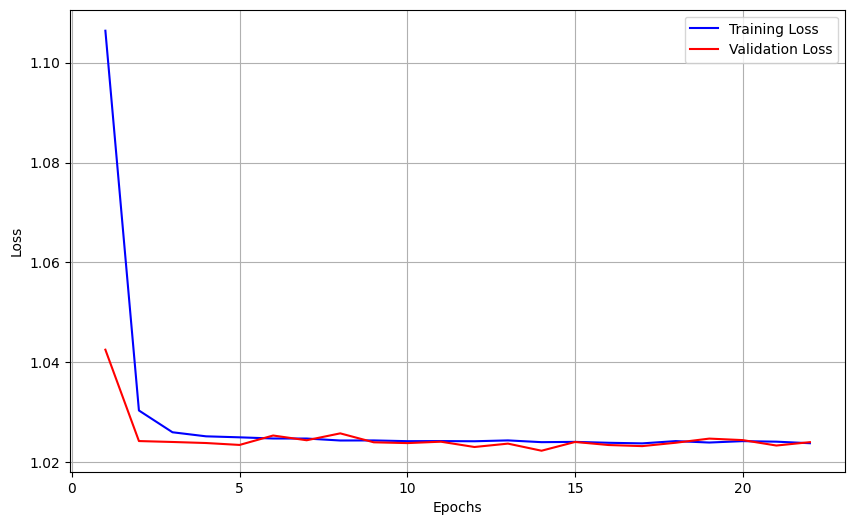

In [14]:
from loss_curve_visualization import plot_loss_curves
plot_loss_curves("D:\Praharsha\code\CAMZ\models\model_history\CNN_loss_logger.csv")

In [ ]:
def load_checkpoint(checkpoint, architecture, optimizer):
    print("loading checkpoint...")
    checkpoint = torch.load(checkpoint)
    
    model = architecture()
    
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    return model.eval()
model = load_checkpoint("D:\Praharsha\code\CAMZ\models\model_history\CNN_checkpoint.pth.tar", CNNModel, optimizer)

In [ ]:
image_path1 = r"E:\DIL\Fish_classification_ViT\data\1Lcrop989.jpg.jpg"
image_path2 = r"E:\DIL\Fish_classification_ViT\data\1Lcrop284.jpg.jpg"
image_path3 = r"E:\DIL\Fish_classification_ViT\data\1Lcrop313.jpg.jpg"

visualize_prediction(image_path1, labels_path=r"E:\DIL\Fish_classification_ViT\data\labels",
                     model=model)
    

In [ ]:
visualize_prediction(image_path2, labels_path=r"E:\DIL\Fish_classification_ViT\data\labels",
                     model=model)

In [ ]:
visualize_prediction(image_path3, labels_path=r"E:\DIL\Fish_classification_ViT\data\labels",
                     model=model)